# Evaluation TAL: Traitement Automatique du Langage

__

Dans ce travail nous avons pour but de démontrer notre capacité à créer une chaine de traitement des données textuelles sur l'analyse d'opinion et la classification de locuteur. Pour ce faire nous aurons deux jeux de données :
- Revues de film
- Chirac/Mitterand

> ## Classification de documents : prise en main des outils
Le but de ce TP est de classer des documents textuels... Dans un premier temps, nous allons vérifier le bon fonctionnement des outils sur des données jouets puis appliquer les concepts sur des données réelles.

> ###      Conception de la chaine de traitement
Pour rappel, une chaine de traitement de documents classique est composée des étapes suivantes:
> 1. Lecture des données et importation
    - Dans le cadre de nos TP, nous faisons l'hypothèse que le corpus tient en mémoire... Si ce n'est pas le cas, il faut alors ajouter des structures de données avec des buffers (*data-reader*), bien plus complexes à mettre en place.
    - Le plus grand piège concerne l'encodage des données. Dans le TP... Pas (ou peu) de problème. Dans la vraie vie: il faut faire attention à toujours maitriser les formats d'entrée et de sortie.
> 2. Traitement des données brutes paramétrique. Chaque traitement doit être activable ou desactivable + paramétrable si besoin.
    - Enlever les informations *inutiles* : chiffre, ponctuations, majuscules, etc... (**L'utilité dépend de l'application!**)
    - Segmenter en mots (=*Tokenization*)
    - Elimination des stop-words
    - Stemming/lemmatisation (racinisation)
    - Byte-pair encoding pour trouver les mots composés (e.g. Sorbonne Université, Ville de Paris, Premier Ministre, etc...)
> 3. Traitement des données numériques
    - Normalisation *term-frequency* / binarisation
    - Normalisation *inverse document frequency*
    - Elimination des mots rares, des mots trop fréquents
    - Construction de critère de séparabilité pour éliminer des mots etc...
> 4. Apprentissage d'un classifieur
    - Choix du type de classifieur
    - Réglage des paramètres du classifieur (régularisation, etc...)

> ### Exploitation de la chaine de traitement
On appelle cette étape la réalisation d'une campagne d'expériences: c'est le point clé que nous voulons traviller en TAL cette année.
> 1. Il est impossible de tester toutes les combinaisons par rapport aux propositions ci-dessus... Il faut donc en éliminer un certain nombre.
    - En discutant avec les experts métiers
    - En faisant des tests préliminaires
> 2. Après ce premier filtrage, il faut:
    - Choisir une évaluation fiable et pas trop lente (validation croisée, leave-one-out, split apprentissage/test simple)
    - Lancer des expériences en grand
        - = *grid-search*
        - parallèliser sur plusieurs machines
        - savoir lancer sur un serveur et se déconnecter
> 3. Collecter et analyser les résultats


>### Inférence
L'inférence est ensuite très classique: la chaine de traitement optimale est apte à traiter de nouveaux documents

In [1]:
import numpy as np
import matplotlib.pyplot as plt #%matplotlib inline
import random as rnd

import codecs
import re
import os.path

## 1. Analyse d'opinion sur des revues de film

**Analyses obligatoires**
- Comparer les performances avec différents pré-traitements
    - e.g Taille de vocabulaire, unigram/bigram, Stemming, ...
- Appliquer les traitements optimaux sur les données de test et sauver les résultats dans un fichier txt

**Compléments optionnels**
- Analyser les performances avec Word2Vec, en utilisant des stratégies d'agrégation naïves


### a) Load Data 

#### i) Load Movies and labs

In [2]:
def load_movies(path2data): # 1 classe par répertoire
    alltxts = [] # init vide
    labs = []
    cpt = 0
    for cl in os.listdir(path2data): # parcours des fichiers d'un répertoire
        for f in os.listdir(path2data+cl):
            txt = open(path2data+cl+'/'+f).read()
            alltxts.append(txt)
            labs.append(cpt)
        cpt+=1 # chg répertoire = cht classe
        
    return alltxts,labs

In [3]:
path = "movies/movies1000/"

alltxts,alllabs = load_movies(path)

In [4]:
print(len(alltxts),len(alllabs))
print(alltxts[0])
print(alllabs[0])
print(alltxts[-1])
print(alllabs[-1])

2000 2000
plot : two teen couples go to a church party , drink and then drive . 
they get into an accident . 
one of the guys dies , but his girlfriend continues to see him in her life , and has nightmares . 
what's the deal ? 
watch the movie and " sorta " find out . . . 
critique : a mind-fuck movie for the teen generation that touches on a very cool idea , but presents it in a very bad package . 
which is what makes this review an even harder one to write , since i generally applaud films which attempt to break the mold , mess with your head and such ( lost highway & memento ) , but there are good and bad ways of making all types of films , and these folks just didn't snag this one correctly . 
they seem to have taken this pretty neat concept , but executed it terribly . 
so what are the problems with the movie ? 
well , its main problem is that it's simply too jumbled . 
it starts off " normal " but then downshifts into this " fantasy " world in which you , as an audience member , 

#### ii) Split data into train and test

In [5]:
size_test = round(0.80*len(alltxts))
index_train_txts = rnd.sample(range(len(alltxts)), size_test)

train_txts = [alltxts[txt] for txt in index_train_txts]
train_labs = [alllabs[txt] for txt in index_train_txts]

test_texts = [alltxts[txt] for txt in range(len(alltxts)) if txt not in index_train_txts]
test_labs = [alllabs[txt] for txt in range(len(alllabs)) if txt not in index_train_txts]

#print(len(alltxts), len(test_texts), len(train_txts))

### b) Preprocessing

> #### Transformation paramétrique du texte
Vous devez tester, par exemple, les cas suivants:
> - transformation en minuscule ou pas
> - suppression de la ponctuation
> - transformation des mots entièrement en majuscule en marqueurs spécifiques
> - suppression des chiffres ou pas
> - conservation d'une partie du texte seulement (seulement la première ligne = titre, seulement la dernière ligne = résumé, ...)
> - stemming
> - ...

> Vérifier systématiquement sur un exemple ou deux le bon fonctionnement des méthodes sur deux documents (au moins un de chaque classe).

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

Dans un premier temps, les documents sont utilisés **sans prétraitement**. Puis nous ajoutons **différents prétraitements** afin de les comparer. Enfin, nous essaierons, si cela semble pertinent, de **combiner les prétraitements** pour optimiser les performances.

In [7]:
#help(CountVectorizer)

#### i) Sans pretraitement

In [8]:
train_txts#Sans pré-traitement
vec_no_PP = CountVectorizer(lowercase=False)
X_no_PP = vec_no_PP.fit_transform(train_txts)
print('Sans pré-traitement : \n', len(vec_no_PP.get_feature_names()), vec_no_PP.get_feature_names()[550:600]) # we only print a few

Sans pré-traitement : 
 36348 ['_survives_', '_that_', '_the', '_the_', '_the_broadway_musical_', '_the_last_days_of_disco_', '_the_lion_king', '_their_', '_there_', '_they', '_this_', '_titanic_', '_titus_', '_titus_andronicus_', '_to', '_today_', '_too_', '_twice_', '_two_', '_unbreakable_', '_vampires_', '_very_', '_very_small_', '_wag', '_wartime', '_wayyyyy_', '_what', '_whole_', '_will_', '_william_shakespeare', '_would_', 'aa', 'aaa', 'aaaaaaaaah', 'aaaaaaaahhhh', 'aaaaaah', 'aaaahhhs', 'aahs', 'aaliyah', 'aalyah', 'aamir', 'aardman', 'aaron', 'aatish', 'ab', 'aback', 'abandon', 'abandoned', 'abandoning', 'abandonment']


C:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


#### ii) Sans ponctuation

In [9]:
def preprocess_p(text):
    """
    Transforms text to remove unwanted bits.
    """
    ponctuation = ["!", ":", ",", ".", "?", "+", "-", "&", "*", "%", "(",")", "_", '"', "'"]
    for p in ponctuation:
        text = text.replace(p," ")
    return text # This function is only taking care of dots, what about !:,?+-&*%

In [10]:
#Clean text ponctuation
vec_Clean = CountVectorizer(preprocessor=preprocess_p)
X_Clean = vec_Clean.fit_transform(train_txts)
print('\n \nTexte sans ponctuation: \n', len(vec_Clean.get_feature_names()), vec_Clean.get_feature_names()[550:600]) # we only print a few


 
Texte sans ponctuation: 
 36108 ['accepts', 'access', 'accessibility', 'accessible', 'accessorize', 'accessory', 'accident', 'accidental', 'accidentally', 'accidentlly', 'accidently', 'accidents', 'acclaim', 'acclaimed', 'acclimatize', 'accolade', 'accolades', 'accommodate', 'accommodates', 'accommodating', 'accommodations', 'accomodates', 'accompanied', 'accompanies', 'accompaniment', 'accompany', 'accompanying', 'accomplice', 'accomplices', 'accomplish', 'accomplished', 'accomplishes', 'accomplishing', 'accomplishment', 'accomplishments', 'accord', 'accordance', 'according', 'accordingly', 'accordion', 'accosted', 'account', 'accountability', 'accountable', 'accountant', 'accountants', 'accounted', 'accounts', 'accumulated', 'accumulation']


#### iii) Sans majuscules

In [11]:
#Clean Text min/Maj
vec_mM = CountVectorizer(lowercase=True)
X_mM = vec_mM.fit_transform(train_txts)
print('\n \nTexte sans majuscules: \n', len(vec_mM.get_feature_names()), vec_mM.get_feature_names()[550:600]) # we only print a few


 
Texte sans majuscules: 
 36348 ['_survives_', '_that_', '_the', '_the_', '_the_broadway_musical_', '_the_last_days_of_disco_', '_the_lion_king', '_their_', '_there_', '_they', '_this_', '_titanic_', '_titus_', '_titus_andronicus_', '_to', '_today_', '_too_', '_twice_', '_two_', '_unbreakable_', '_vampires_', '_very_', '_very_small_', '_wag', '_wartime', '_wayyyyy_', '_what', '_whole_', '_will_', '_william_shakespeare', '_would_', 'aa', 'aaa', 'aaaaaaaaah', 'aaaaaaaahhhh', 'aaaaaah', 'aaaahhhs', 'aahs', 'aaliyah', 'aalyah', 'aamir', 'aardman', 'aaron', 'aatish', 'ab', 'aback', 'abandon', 'abandoned', 'abandoning', 'abandonment']


#### iv) Sans stop words

In [12]:
from collections import Counter

def most_common_words(texts, n):
    """
    """
    wc = Counter()
    for txt in texts:
        wc.update(txt.split(" "))
    
    freq = [f for w,f in wc.most_common(1000)]
    stop_words = [w for w,f in wc.most_common(n)]
    return stop_words

In [13]:
#Remove stop words
stop_words = most_common_words(train_txts, 20)
vec_noSW_freq = CountVectorizer(stop_words=stop_words)
X_noSW_freq = vec_noSW_freq.fit_transform(train_txts)
print('\n \nSans stop words (frequents) : \n', len(vec_noSW_freq.get_feature_names()), vec_noSW_freq.get_feature_names()[600:700]) # we only print a few

vec_noSW = CountVectorizer(stop_words={'english'})
X_noSW = vec_noSW.fit_transform(train_txts)
print('\n \nSans stop words (par défaut) : \n', len(vec_noSW.get_feature_names()), vec_noSW.get_feature_names()[550:600]) # we only print a few


 
Sans stop words (frequents) : 
 36334 ['abandons', 'abating', 'abba', 'abberation', 'abbots', 'abbott', 'abbotts', 'abbreviated', 'abby', 'abc', 'abdomen', 'abducted', 'abductees', 'abduction', 'abductions', 'abdul', 'abe', 'abel', 'aberdeen', 'aberration', 'abetted', 'abetting', 'abeyance', 'abhorrence', 'abhorrent', 'abiility', 'abilities', 'ability', 'abject', 'ablaze', 'able', 'ably', 'abnormal', 'abo', 'aboard', 'abode', 'abolish', 'abolitionist', 'abolitionists', 'abominable', 'abomination', 'aborbed', 'abort', 'aborted', 'abortion', 'abortionist', 'abortions', 'abortive', 'abound', 'abounded', 'abounding', 'abounds', 'about', 'abouts', 'above', 'abraded', 'abraham', 'abrahams', 'abrams', 'abrasive', 'abroad', 'abrupt', 'abruptly', 'abs', 'absence', 'absences', 'absense', 'absent', 'absinthe', 'absoloute', 'absolut', 'absolute', 'absolutely', 'absolutes', 'absolution', 'absolutist', 'absolved', 'absorb', 'absorbed', 'absorbing', 'absorbs', 'absorption', 'abstinence', 'abstract

#### v) Sans chiffres

In [14]:
def preprocess_c(text):
    """
    Transforms text to remove unwanted bits.
    """
    chiffres = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
    for c in chiffres:
        text = text.replace(c," ")
    return text # This function is only taking care of dots, what about !:,?+-&*%

In [15]:
#suppression des chiffres
vec_noNb = CountVectorizer(preprocessor=preprocess_c)
X_noNb = vec_noNb.fit_transform(train_txts)
print('\n \nTexte sans chiffres: \n', len(vec_noNb.get_feature_names()), vec_noNb.get_feature_names()[550:600]) # we only print a few


 
Texte sans chiffres: 
 35913 ['adlai', 'adlib', 'administered', 'administering', 'administration', 'administrative', 'administrator', 'admirable', 'admirably', 'admirals', 'admiration', 'admire', 'admired', 'admirer', 'admirers', 'admires', 'admiring', 'admission', 'admit', 'admitedly', 'admiting', 'admits', 'admittance', 'admitted', 'admittedly', 'admitting', 'admittingly', 'admonition', 'ado', 'adolescence', 'adolescent', 'adolescents', 'adolf', 'adolph', 'adopt', 'adopted', 'adopting', 'adoption', 'adoptive', 'adopts', 'adorable', 'adorableness', 'adorably', 'adoration', 'adore', 'adored', 'adores', 'adoring', 'adorn', 'adorned']


#### vi) Conservation d'une partie du texte seulement

In [16]:
#conservation d'une partie du texte seulement (seulement la première ligne = titre, seulement la dernière ligne = résumé, ...)

def preprocess_titre(text):
    """
    Transforms text to keep only the fisrt row.
    """
    ligne = text.split('\n')
    text = ligne[0]
    return text

def preprocess_resume(text):
    """
    Transforms text to keep only the last row.
    """
    ligne = text.split('\n')
    i = -1
    while ligne[i] == '':
        i-=1
    text = ligne[i]
    return text

In [17]:
#Part of the text
vec_title = CountVectorizer(preprocessor=preprocess_titre)
X_title = vec_title.fit_transform(train_txts)
print('\n \nTexte réduit à son titre : \n', len(vec_title.get_feature_names()), vec_title.get_feature_names()[550:600]) 

vec_resume = CountVectorizer(preprocessor=preprocess_resume)
X_resume = vec_resume.fit_transform(train_txts)
print('\n \nTexte réduit à son résumé : \n', len(vec_resume.get_feature_names()), vec_resume.get_feature_names()[550:600]) 



 
Texte réduit à son titre : 
 6855 ['avid', 'avoid', 'avowed', 'awaited', 'awaits', 'awake', 'awaken', 'awakenings', 'award', 'awarded', 'awards', 'aware', 'away', 'awe', 'awesome', 'awful', 'awhile', 'awkward', 'axe', 'ayla', 'baadasssss', 'babe', 'babies', 'baby', 'babysitting', 'bachelor', 'back', 'backdrop', 'background', 'backlash', 'backs', 'bacon', 'bad', 'badly', 'badness', 'bait', 'baldwin', 'ball', 'ballet', 'ballistic', 'ballyhoo', 'banana', 'bananas', 'band', 'bandaged', 'banderas', 'bandits', 'bang', 'banished', 'bank']

 
Texte réduit à son résumé : 
 5187 ['boast', 'bob', 'body', 'boldly', 'bolt', 'bomb', 'bond', 'bone', 'boneheaded', 'bont', 'boogie', 'boogieman', 'book', 'books', 'bopper', 'bordering', 'borderline', 'bore', 'bored', 'boring', 'born', 'borrowers', 'boss', 'both', 'bother', 'bottle', 'bottom', 'bound', 'bow', 'box', 'boxing', 'boy', 'boyfriend', 'boyle', 'boys', 'brad', 'brain', 'brainers', 'branagh', 'brandon', 'brasco', 'bratty', 'brauva', 'brazil', 

#### vii) Vocabulaire réduit

In [18]:
#Variation de la taille du vocabulaire #####PARAMS A CHANGER
vec_sizeVoc = CountVectorizer(max_df=100000,min_df=5,max_features=25000) #Changer params
X_sizeVoc = vec_sizeVoc.fit_transform(train_txts)
print('\n \nVocabulaire réduit : \n', len(vec_sizeVoc.get_feature_names()), vec_sizeVoc.get_feature_names()[550:600])


 
Vocabulaire réduit : 
 11617 ['anybody', 'anyhow', 'anymore', 'anyone', 'anything', 'anytime', 'anyway', 'anywhere', 'apart', 'apartment', 'ape', 'apes', 'aphrodite', 'apocalypse', 'apocalyptic', 'apollo', 'apologize', 'appalling', 'apparent', 'apparently', 'apparitions', 'appeal', 'appealing', 'appeals', 'appear', 'appearance', 'appearances', 'appeared', 'appearing', 'appears', 'applaud', 'applauded', 'applause', 'apple', 'applied', 'applies', 'apply', 'appointed', 'appreciate', 'appreciated', 'appreciation', 'apprentice', 'approach', 'approached', 'approaches', 'approaching', 'appropriate', 'appropriately', 'approximately', 'april']


#### viii) N-gram

In [19]:
#Unigram/bigram #####PARAMS A CHANGER
N_gram = (2,2)
vec_ngram22 = CountVectorizer(ngram_range=N_gram,analyzer='word') # Maybe 2-grams or 3-grams bring improvements ?
X_ngram22 = vec_ngram22.fit_transform(train_txts)
print(f'\n \n N-gram {N_gram}: \n', len(vec_ngram22.get_feature_names()), vec_ngram22.get_feature_names()[550:600])

N_gram = (3,3)
vec_ngram33 = CountVectorizer(ngram_range=N_gram,analyzer='word') 
X_ngram33 = vec_ngram33.fit_transform(train_txts)
print(f'\n \n N-gram {N_gram}: \n', len(vec_ngram33.get_feature_names()), vec_ngram33.get_feature_names()[550:600])

N_gram = (1,2)
vec_ngram12 = CountVectorizer(ngram_range=N_gram,analyzer='word') 
X_ngram12 = vec_ngram12.fit_transform(train_txts)
print(f'\n \n N-gram {N_gram}: \n', len(vec_ngram12.get_feature_names()), vec_ngram12.get_feature_names()[550:600])

N_gram = (1,3)
vec_ngram13 = CountVectorizer(ngram_range=N_gram,analyzer='word') 
X_ngram13 = vec_ngram13.fit_transform(train_txts)
print(f'\n \n N-gram {N_gram}: \n', len(vec_ngram13.get_feature_names()), vec_ngram13.get_feature_names()[550:600])



 
 N-gram (2, 2): 
 419020 ['165 mph', '16mm 35mm', '16mm camera', '16mm film', '16mm was', '16th century', '16th floor', '16x9 televisions', '17 1997', '17 and', '17 but', '17 cannot', '17 contains', '17 day', '17 days', '17 for', '17 hell', '17 in', '17 long', '17 mainly', '17 or', '17 people', '17 pg', '17 rated', '17 rating', '17 the', '17 those', '17 to', '17 whatever', '17 year', '17 years', '170 minutes', '1700s suddenly', '1709 is', '175 million', '175 years', '1773 he', '1791 louisiana', '1792 she', '1793 but', '1794 bold', '1799 sleepy', '17th appearance', '17th birthday', '17th century', '18 16', '18 1998', '18 albany', '18 and', '18 bond']

 
 N-gram (3, 3): 
 805619 ['115 minutes considering', '115 minutes the', '117 minutes directed', '118 minutes not', '11th hour regurgitation', '11th hour reshoots', '12 000 just', '12 1999 10', '12 2001 that', '12 99 the', '12 and 13', '12 and up', '12 and watching', '12 angry men', '12 deal with', '12 fingered piano', '12 gold chains'

#### ix) Stemming

In [20]:
#Stemming
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize 

def preprocess_stemming(text):
    """
    Transforms text to keep only stemmed words.
    """
    ps = PorterStemmer()
    tokens = word_tokenize(text)
    stemmed = ''
    for token in tokens:
        stemmed_word = ps.stem(token)
        stemmed += (' ' + stemmed_word)
    return stemmed

In [21]:
#stemming
vec_stem = CountVectorizer(preprocessor=preprocess_stemming)
X_stem = vec_stem.fit_transform(train_txts)
print('\n \nTexte avec stemming : \n', len(vec_stem.get_feature_names()), vec_stem.get_feature_names()[550:600]) 


 
Texte avec stemming : 
 25063 ['_unbreakable_', '_vampires_', '_very_', '_very_small_', '_wag', '_wartim', '_wayyyyy_', '_what', '_whole_', '_will_', '_william_shakespeare', '_would_', 'aa', 'aaa', 'aaaaaaaaah', 'aaaaaaaahhhh', 'aaaaaah', 'aaaahhh', 'aah', 'aaliyah', 'aalyah', 'aamir', 'aardman', 'aaron', 'aatish', 'ab', 'aback', 'abandon', 'abat', 'abba', 'abber', 'abbi', 'abbot', 'abbott', 'abbrevi', 'abc', 'abdomen', 'abduct', 'abducte', 'abdul', 'abe', 'abel', 'aberdeen', 'aberr', 'abet', 'abey', 'abhorr', 'abiil', 'abil', 'abject']


#### x) POS

In [22]:
#Part of speech tagging (POS)
from nltk.tag import pos_tag
import nltk
#nltk.download('averaged_perceptron_tagger')

def preprocess_pos(text):
    """
    Transforms text to keep only adjectives
    """
    tokens = word_tokenize(text)
    pt = pos_tag(tokens)
    pos = [word for word, tag in pt if tag =='JJ' or tag =='JJR' or tag =='JJS'] #adjectives
    tagged = ''
    for w in pos:
        tagged += (' ' + w)
    return tagged

In [23]:
#pos
vec_pos = CountVectorizer(preprocessor=preprocess_pos)
X_pos = vec_pos.fit_transform(train_txts)
print('\n \nTexte avec part of speech tagging : \n', len(vec_pos.get_feature_names()), vec_pos.get_feature_names()[550:600]) 


 
Texte avec part of speech tagging : 
 11794 ['animatronic', 'anime', 'aniston', 'anita', 'anjelica', 'ann', 'anna', 'annabella', 'anne', 'annette', 'anney', 'annie', 'anniversary', 'annoyed', 'annoying', 'annual', 'anomaly', 'anonymous', 'answering', 'ant', 'antagonist', 'antagonistic', 'antarctic', 'antennae', 'anthology', 'anthony', 'anthro', 'anti', 'anticipated', 'anticlimactic', 'anticlimatic', 'anticlimaxic', 'antionio', 'antique', 'antiseptic', 'antisocial', 'antoine', 'antonio', 'antsy', 'antwerp', 'antz', 'anxiety', 'anxious', 'aoki', 'aol', 'apartheid', 'apathy', 'ape', 'apes', 'apocalypse']


Nous gardons alors les prétraitements qui nous intéressent pour la suite :

In [24]:
preprocessing = ['Sans pré-traitement', 
                 'Sans ponctuation', 
                 'Sans majuscules', 
                 'Sans stop words fréquents',
                 'Sans stop words par défaut',
                 'Sans chiffres',
                 'Conservation du titre',
                 'Conservation du résumé', 
                 'Vocabulaire réduit', 
                 'N-gram (2,2)',
                 'N-gram (3,3)',
                 'N-gram (1,2)',
                 'N-gram (1,3)',
                 'Stemming',
                 'Part of speech tagging']

prepross_X = [X_no_PP, X_Clean, X_mM, X_noSW_freq, X_noSW, X_noNb, X_title, 
              X_resume, X_sizeVoc, X_ngram22, X_ngram33, X_ngram12, X_ngram13,
              X_stem, X_pos]

pp_vectorizer = [vec_no_PP, vec_Clean, vec_mM, vec_noSW_freq, vec_noSW, vec_noNb, vec_title, 
                 vec_resume, vec_sizeVoc, vec_ngram22, vec_ngram33, vec_ngram12, vec_ngram13,
                 vec_stem, vec_pos]

### c) Extraction du vocabulaire

> #### Exploration préliminaire des jeux de données.
> - Quelle est la taille d'origine du vocabulaire?
> - Que reste-t-il si on ne garde que les 100 mots les plus fréquents? [word cloud]
> - Quels sont les 100 mots dont la fréquence documentaire est la plus grande? [word cloud]
> - Quels sont les 100 mots les plus discriminants au sens de odds ratio? [word cloud]
> - Quelle est la distribution d'apparition des mots (Zipf)
> - Quels sont les 100 bigrammes/trigrammes les plus fréquents?

### d) Training and Testing

> #### Modèles de Machine Learning
Avant de lancer de grandes expériences, il faut se construire une base de travail solide en étudiant les questions suivantes:
> - Combien de temps ça prend d'apprendre un classifieur NB/SVM/RegLog sur ces données en fonction de la taille du vocabulaire?
> - La validation croisée est-elle nécessaire? Est ce qu'on obtient les mêmes résultats avec un simple *split*?
> - La validation croisée est-elle stable? A partir de combien de fold (travailler avec différentes graines aléatoires et faire des statistiques basiques)?

> #### Première campagne d'expériences
Les techniques sur lesquelles nous travaillons étant sujettes au sur-apprentissage: trouver le paramètre de régularisation dans la documentation et optimiser ce paramètre au sens de la métrique qui vous semble la plus appropriée (cf question précédente).

> #### Equilibrage des données
Un problème reconnu comme dur dans la communauté est celui de l'équilibrage des classes (*balance* en anglais). Que faire si les données sont à 80, 90 ou 99% dans une des classes?
Le problème est dur mais fréquent; les solutions sont multiples mais on peut isoler 3 grandes familles de solution.
> 1. Ré-équilibrer le jeu de données: supprimer des données dans la classe majoritaire et/ou sur-échantilloner la classe minoritaire.
   $\Rightarrow$ A vous de jouer pour cette technique
> 2. Changer la formulation de la fonction de coût pour pénaliser plus les erreurs dans la classe minoritaire:
soit une fonction $\Delta$ mesurant les écarts entre $f(x_i)$ et $y_i$ 
$$C = \sum_i  \alpha_i \Delta(f(x_i),y_i), \qquad \alpha_i = \left\{
\begin{array}{ll}
1 & \text{si } y_i \in \text{classe majoritaire}\\
B>1 & \text{si } y_i \in \text{classe minoritaire}\\
\end{array} \right.$$
   $\Rightarrow$ Les SVM et d'autres approches sklearn possèdent des arguments pour régler $B$ ou $1/B$... Ces arguments sont utiles mais pas toujours suffisant.
> 3. Courbe ROC et modification du biais. Une fois la fonction $\hat y = f(x)$ apprise, il est possible de la *bidouiller* a posteriori: si toutes les prédictions $\hat y$ sont dans une classe, on va introduire $b$ dans $\hat y = f(x) + b$ et le faire varier jusqu'à ce qu'un des points change de classe. On peut ensuite aller de plus en plus loin.
Le calcul de l'ensemble des scores associés à cette approche mène directement à la courbe ROC.
**Note:** certains classifieurs sont intrinsèquement plus résistante au problème d'équilibrage, c'est par exemple le cas des techniques de gradient boosting que vous verrez l'an prochain.

In [25]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

NB_acc_score = []
LR_acc_score = []
SVM_acc_score = []

for index in range(len(prepross_X)):
    #TRAIN
    pp = preprocessing[index]
    X = prepross_X[index]
    vectorizer = pp_vectorizer[index]
    
    #Naïve Bayes
    nb_clf = MultinomialNB()
    nb_clf.fit(X, train_labs)


    #Logistic Regression
    lr_clf = LogisticRegression(random_state=0, solver='lbfgs',n_jobs=-1)
    lr_clf.fit(X, train_labs)

    #Linear SVM
    svm_clf = LinearSVC(random_state=0, tol=1e-5)
    svm_clf.fit(X, train_labs)

    #TEST
    true = test_labs #[pol for text,pol in alltxts]
    #train_corpus = alltxts #[text for text,pol in alltxts]
    X_test = vectorizer.transform(test_texts)

    pred_nb = nb_clf.predict(X_test)
    pred_lr = lr_clf.predict(X_test)
    pred_svm = svm_clf.predict(X_test)

    print('\n', pp)
    print(f"Naïve Bayes accuracy: {accuracy_score(true, pred_nb)}")
    print(f"Logistic Regression accuracy: {accuracy_score(true, pred_lr)}")
    print(f"SVM accuracy: {accuracy_score(true, pred_svm)}")
    
    NB_acc_score.append(accuracy_score(true, pred_nb))
    LR_acc_score.append(accuracy_score(true, pred_lr))
    SVM_acc_score.append(accuracy_score(true, pred_svm))



 Sans pré-traitement
Naïve Bayes accuracy: 0.805
Logistic Regression accuracy: 0.8475
SVM accuracy: 0.84

 Sans ponctuation
Naïve Bayes accuracy: 0.805
Logistic Regression accuracy: 0.855
SVM accuracy: 0.84

 Sans majuscules
Naïve Bayes accuracy: 0.805
Logistic Regression accuracy: 0.8475
SVM accuracy: 0.84

 Sans stop words fréquents
Naïve Bayes accuracy: 0.81
Logistic Regression accuracy: 0.85
SVM accuracy: 0.835

 Sans stop words par défaut
Naïve Bayes accuracy: 0.805
Logistic Regression accuracy: 0.8475
SVM accuracy: 0.84

 Sans chiffres
Naïve Bayes accuracy: 0.8075
Logistic Regression accuracy: 0.8525
SVM accuracy: 0.83

 Conservation du titre
Naïve Bayes accuracy: 0.57
Logistic Regression accuracy: 0.5575
SVM accuracy: 0.56

 Conservation du résumé
Naïve Bayes accuracy: 0.63
Logistic Regression accuracy: 0.645
SVM accuracy: 0.615

 Vocabulaire réduit
Naïve Bayes accuracy: 0.83
Logistic Regression accuracy: 0.85
SVM accuracy: 0.83


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 N-gram (2,2)
Naïve Bayes accuracy: 0.8325
Logistic Regression accuracy: 0.8075
SVM accuracy: 0.8125


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 N-gram (3,3)
Naïve Bayes accuracy: 0.805
Logistic Regression accuracy: 0.775
SVM accuracy: 0.78


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 N-gram (1,2)
Naïve Bayes accuracy: 0.835
Logistic Regression accuracy: 0.8525
SVM accuracy: 0.86


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 N-gram (1,3)
Naïve Bayes accuracy: 0.795
Logistic Regression accuracy: 0.8425
SVM accuracy: 0.845


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 Stemming
Naïve Bayes accuracy: 0.8175
Logistic Regression accuracy: 0.855
SVM accuracy: 0.8475

 Part of speech tagging
Naïve Bayes accuracy: 0.8225
Logistic Regression accuracy: 0.8225
SVM accuracy: 0.7925


### e) Performances

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

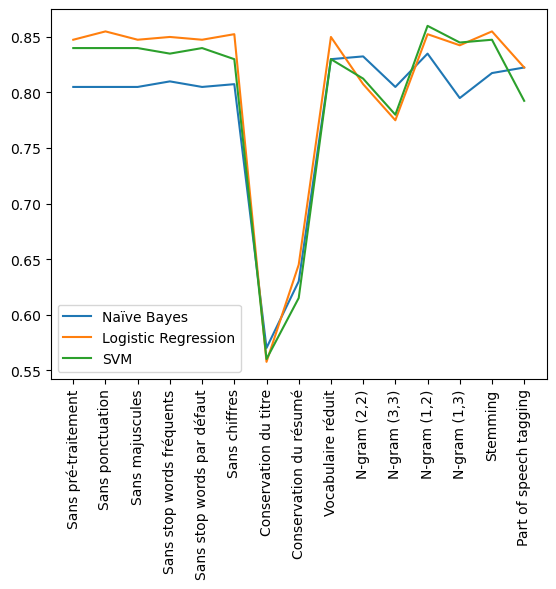

In [26]:
#Plots
plt.plot(preprocessing, NB_acc_score, label = 'Naïve Bayes')
plt.plot(preprocessing, LR_acc_score, label = 'Logistic Regression')
plt.plot(preprocessing, SVM_acc_score, label = 'SVM')
plt.legend(loc='lower left')
plt.xticks(rotation = 90)

In [27]:
#Selection des meilleurs pp et classifiers
index_NB = np.argmax(NB_acc_score) #Choisir un autre classifieur ?
index_LR = np.argmax(LR_acc_score)
index_SVM = np.argmax(SVM_acc_score)
print('Max NB : ', preprocessing[index_NB])
print('Max LR : ', preprocessing[index_LR])
print('Max SVM : ', preprocessing[index_SVM])
#index_max = np.argmax()
#print('Max preprocessing and classifier : ', max(preprocessing[index_NB], preprocessing[index_LR], preprocessing[index_SVM]))

Max NB :  N-gram (1,2)
Max LR :  Sans ponctuation
Max SVM :  N-gram (1,2)


#### iv) Combinaison de prétraitements ? Classifieurs et Performances

In [28]:
Preprocessings = [('Sans ponctuation', preprocess_p) ,
                 ('Sans chiffres', preprocess_c),
                 ('Conservation du titre', preprocess_titre),
                 ('Conservation du résumé', preprocess_resume), 
                 ('Stemming', preprocess_stemming),
                 ('Part of speech tagging', preprocess_pos)]

In [29]:
def combinaison_pp(preprocessing_functions : list):
    """
    Returns a preprocessing function which combines the preprocessings for a text
    Input : (preprocessing_functions) List of preprocessing functions
    Output : (inner) function
    """
    def inner(text):
        for function in preprocessing_functions:
            text = function(text)
        return text
    return inner

In [30]:
from copy import deepcopy

X_tot = []
Names_tot = []
vec_tot = []
ticks = []

n = len(Preprocessings)
p = deepcopy(Preprocessings)
for x in range(n):
    m = len(p)
    for j in range(1,m):
        preprocessing_functions = p[:j]
        
        name_preprocessing = [name for name, function in preprocessing_functions]
        function_preprocessing = [function for name, function in preprocessing_functions]
        
        preprocess = combinaison_pp(function_preprocessing)
        
        vec_combin = CountVectorizer(preprocessor=preprocess)
        X_combin = vec_combin.fit_transform(train_txts)
        
        X_tot.append(X_combin)
        Names_tot.append(name_preprocessing)
        vec_tot.append(vec_combin)
        ticks.append(' + '.join(name_preprocessing))
        
    p = p[1:m]

In [31]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

NB_acc_score = []
LR_acc_score = []
SVM_acc_score = []

for index in range(len(X_tot)):
    #TRAIN
    pp = Names_tot[index]
    X = X_tot[index]
    vectorizer = vec_tot[index]
    
    #Naïve Bayes
    nb_clf = MultinomialNB()
    nb_clf.fit(X, train_labs)


    #Logistic Regression
    lr_clf = LogisticRegression(random_state=0, solver='lbfgs',n_jobs=-1)
    lr_clf.fit(X, train_labs)

    #Linear SVM
    svm_clf = LinearSVC(random_state=0, tol=1e-5)
    svm_clf.fit(X, train_labs)

    #TEST
    true = test_labs #[pol for text,pol in alltxts]
    #train_corpus = alltxts #[text for text,pol in alltxts]
    X_test = vectorizer.transform(test_texts)

    pred_nb = nb_clf.predict(X_test)
    pred_lr = lr_clf.predict(X_test)
    pred_svm = svm_clf.predict(X_test)

    print('\n', pp)
    print(f"Naïve Bayes accuracy: {accuracy_score(true, pred_nb)}")
    print(f"Logistic Regression accuracy: {accuracy_score(true, pred_lr)}")
    print(f"SVM accuracy: {accuracy_score(true, pred_svm)}")
    
    NB_acc_score.append(accuracy_score(true, pred_nb))
    LR_acc_score.append(accuracy_score(true, pred_lr))
    SVM_acc_score.append(accuracy_score(true, pred_svm))


 ['Sans ponctuation']
Naïve Bayes accuracy: 0.805
Logistic Regression accuracy: 0.855
SVM accuracy: 0.84


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 ['Sans ponctuation', 'Sans chiffres']
Naïve Bayes accuracy: 0.8075
Logistic Regression accuracy: 0.855
SVM accuracy: 0.835

 ['Sans ponctuation', 'Sans chiffres', 'Conservation du titre']
Naïve Bayes accuracy: 0.565
Logistic Regression accuracy: 0.5625
SVM accuracy: 0.54

 ['Sans ponctuation', 'Sans chiffres', 'Conservation du titre', 'Conservation du résumé']
Naïve Bayes accuracy: 0.565
Logistic Regression accuracy: 0.5625
SVM accuracy: 0.54

 ['Sans ponctuation', 'Sans chiffres', 'Conservation du titre', 'Conservation du résumé', 'Stemming']
Naïve Bayes accuracy: 0.585
Logistic Regression accuracy: 0.6075
SVM accuracy: 0.5775

 ['Sans chiffres']
Naïve Bayes accuracy: 0.8075
Logistic Regression accuracy: 0.8525
SVM accuracy: 0.83

 ['Sans chiffres', 'Conservation du titre']
Naïve Bayes accuracy: 0.565
Logistic Regression accuracy: 0.56
SVM accuracy: 0.535

 ['Sans chiffres', 'Conservation du titre', 'Conservation du résumé']
Naïve Bayes accuracy: 0.565
Logistic Regression accuracy: 

C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 ['Stemming']
Naïve Bayes accuracy: 0.8175
Logistic Regression accuracy: 0.855
SVM accuracy: 0.8475


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

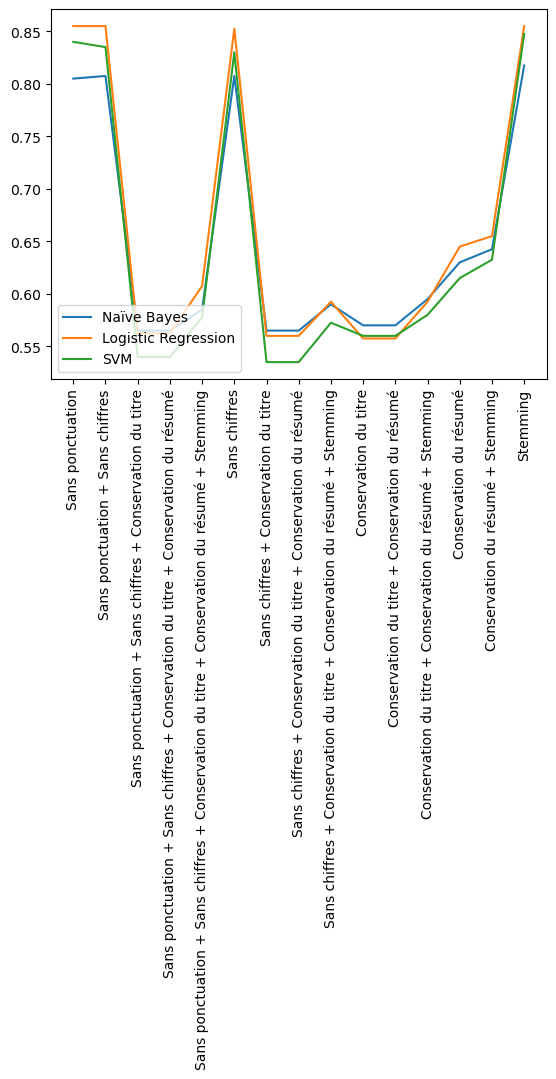

In [32]:
#Plots 

plt.plot(ticks, NB_acc_score, label = 'Naïve Bayes')
plt.plot(ticks, LR_acc_score, label = 'Logistic Regression')
plt.plot(ticks, SVM_acc_score, label = 'SVM')
plt.legend(loc='lower left')
plt.xticks(rotation = 90)

### f) Save results

### g) Compléments Optionnels W2V

## 2. classification de locuteur sur des discours de Chirac et Mitterrand

**Analyses obligatoires**
- Comparer les performances avec différents pré-traitements
    - e.g Taille de vocabulaire, unigram/bigram, Stemming, ...
- Implémenter un post-traitement sur les données Chirac/mittérrand
- Appliquer les traitements optimaux sur les données de test et sauver les résultats dans un fichier txt

**Compléments optionnels**
- Analyser les performances avec Word2Vec, en utilisant des stratégies d'agrégation naïves
